# Euclidean and Energy distances

Calculating Euclidean and Energy distances between perturbations

In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import pertpy as pt

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
import scanpy as sc
import numpy as np
import pertpy as pt
import matplotlib.pyplot as plt
from seaborn import clustermap

## Loading the Dataset

In [93]:
adata = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/D7-filtered_guides.h5ad')
#define 'sgRNA_effecitve' as sgRNAs that are not non-targeting
adata.obs['sgRNA_effecitve'] = [','.join(list(set(i for i in x.split(',') if not i.lower().startswith('non-targeting')))) for x in adata.obs['sgRNA'].astype(str)]
adata.obs['sgRNA_effecitve'] = ['non-targeting' if x == '' else x for x in adata.obs['sgRNA_effecitve']]
adata.obs['num_sgRNA_effective'] = [len(list(set(x.split(',')))) for x in adata.obs['sgRNA_effecitve'].astype(str)]
adata = adata[adata.obs['num_sgRNA_effective'] == 1]
adata = adata[adata.obs['gene_NKS'] != 'WT']
adata = adata[adata.obs['gene_NKS'] != 'nan']
#adata.obs['gene_NKS'] = adata.obs['gene_NKS'].astype(str) + ' KD'

#removev guides that had <25% KD (log2FC > -0.4)
import os
import pandas as pd
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/2D_guides_bulk'
df = pd.read_csv(os.path.join(dir, 'min_log2FC.csv'),index_col=0)
adata = adata[~adata.obs['sgRNA_effecitve'].isin(df[df['log2FC'] > -0.4]['guide'].to_list())]

## Calculating Distances

In [107]:
obs_key = 'gene_NKS' 
distance = pt.tl.Distance(metric='euclidean', obsm_key='X_scANVI')
df = distance.pairwise(adata, groupby=obs_key)
distance1  = pd.DataFrame(df.loc['non-targeting KD'])
distance1['euclidean'] = distance1['non-targeting KD']
distance = pt.tl.Distance(metric='edistance', obsm_key='X_scANVI')
df = distance.pairwise(adata, groupby=obs_key)
distance2  = pd.DataFrame(df.loc['non-targeting KD'])
distance1['edistance'] = distance2['non-targeting KD']
distance1.to_csv('/wynton/group/pollen/jding/brainchromatin/HM2D/distance.2D.csv')

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:08:06

In [65]:
obs_key = 'sgRNA_effecitve' 
distance = pt.tl.Distance(metric='euclidean', obsm_key='X_scANVI')
df = distance.pairwise(adata, groupby=obs_key)
distance = pd.DataFrame(index = df.index)
#calculate mean of intraguide and interguide distance
distance['intragene_guides'] = [df.loc[x, [i for i in df.index if i.split('_')[0] == x.split('_')[0] and i != x]].mean() for x in df.index]
distance['intergene_guides'] = [df.loc[x, [i for i in df.index if i.split('_')[0] != x.split('_')[0]]].mean() for x in df.index]

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:13

<Figure size 640x480 with 0 Axes>

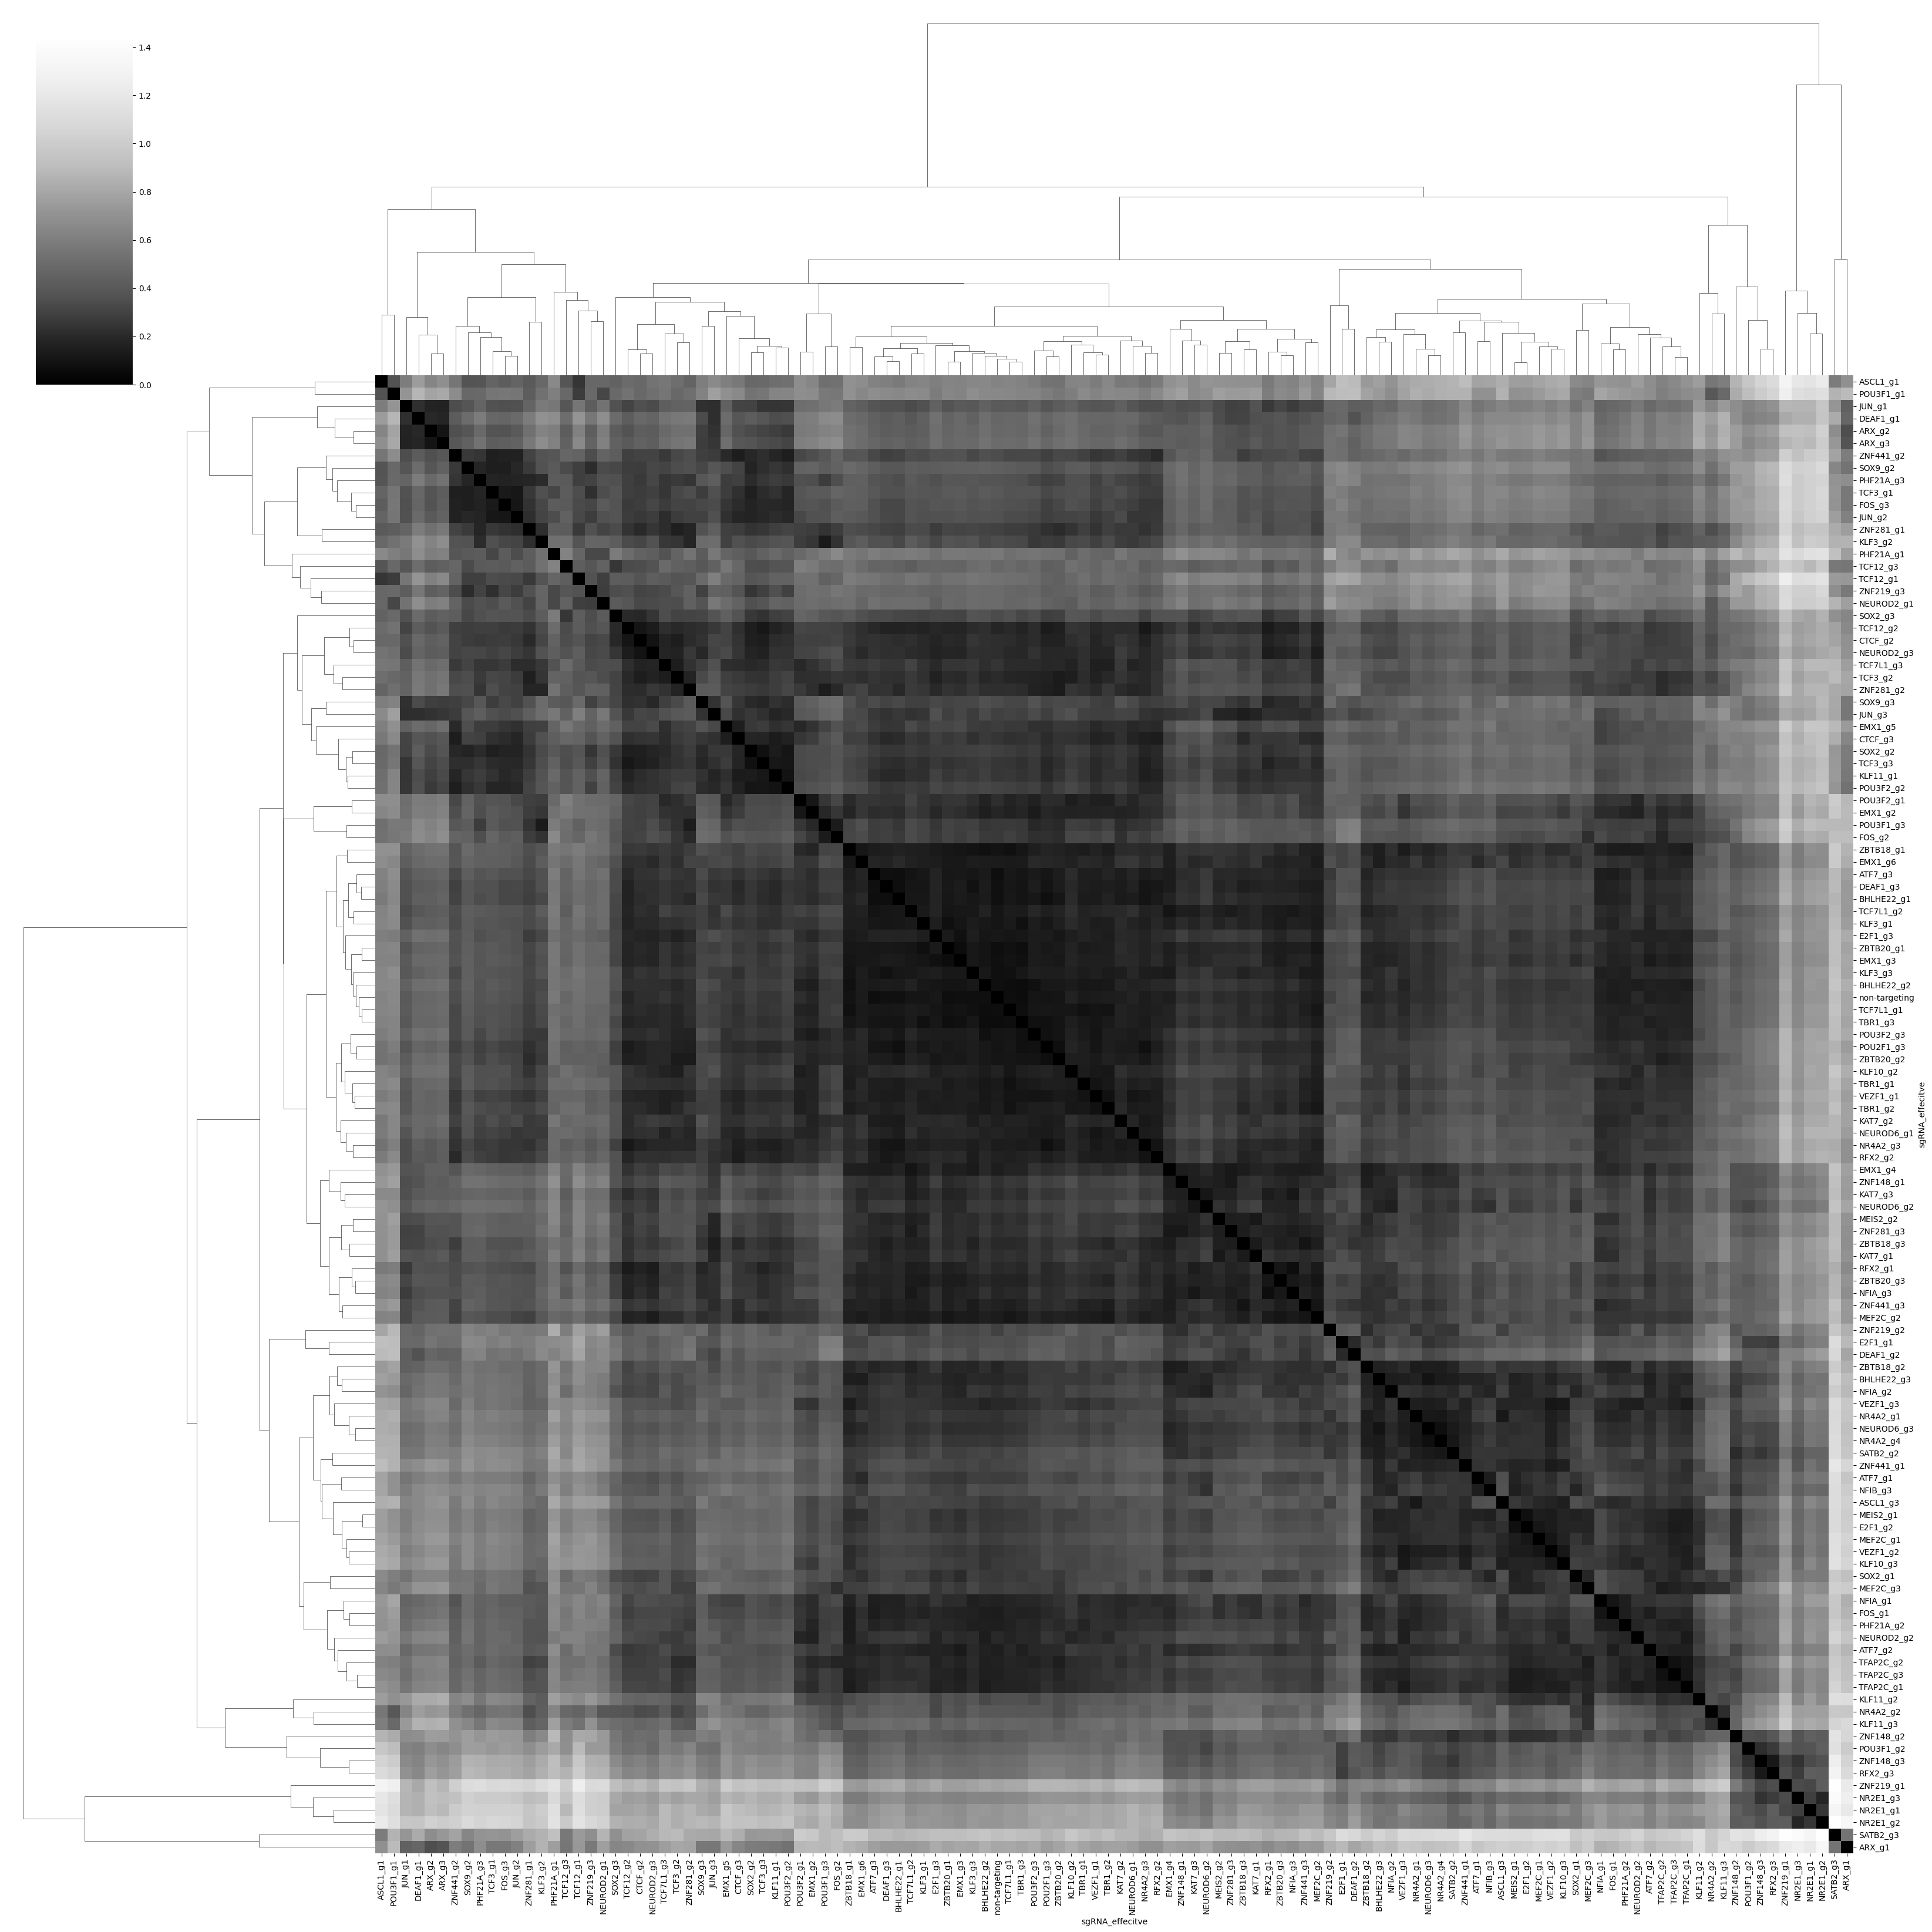

In [37]:
obs_key = 'sgRNA_effecitve' 
distance = pt.tl.Distance(metric='euclidean', obsm_key='X_scANVI')
df = distance.pairwise(adata, groupby=obs_key)
import seaborn as sns
plt.figure()
sns.clustermap(df , vmin=0, cmap = 'Greys_r' ,cbar_kws={'shrink': 0.4},figsize=(35, 35))
plt.savefig('/wynton/home/pollenlab/jding/BrainChromatin/macaque/figures/2D.guides.euclidean.pdf', bbox_inches='tight')

### Specific Cluster Similarities

Let's say we want to find to find out if cluster 4 is more similar to cluster 0 or to cluster 3. 
We can do this by computing the distance between cluster 4 and the other two as follows:

In [ ]:
distance = pt.tl.Distance('edistance', obsm_key='X_pca')
df = distance.pairwise(adata[adata.obs.leiden.isin(['0', '3', '4'])], groupby='leiden', verbose=False)

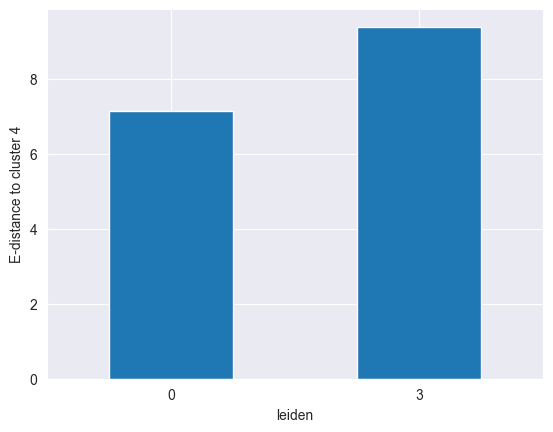

In [47]:
df['4'][['0', '3']].plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('E-distance to cluster 4')
plt.show()

We can clearly see that cluster 4 is more similar to cluster 0 than to cluster 3, as it has a lower distance to the former.

See the [statistical testing notebook](statistical_testing.ipynb) for an example.